# VolSense Notebook 01 — Data Preparation & Feature Engineering

This notebook demonstrates the **complete preprocessing pipeline** for VolSense:

- Fetching OHLCV data using `yfinance`
- Building multi-ticker datasets using `volsense_core.data.fetch`
- Generating realized volatility and engineered features via `feature_engineering.py`

You’ll end up with a clean, feature-rich dataset ready for model training or inference.

In [1]:
# Imports

import matplotlib.pyplot as plt
import os

from volsense_core.data.fetch import fetch_ohlcv, build_dataset
from volsense_core.data.feature_engineering import build_features

## 1️⃣ Define parameters
We’ll specify:
- Ticker universe
- Date range
- Rolling window length for realized volatility calculation

In [2]:
TICKERS = ["AAPL", "MSFT", "SPY", "NVDA", "META"]
START_DATE = "2015-01-01"
END_DATE = "2025-12-31"
LOOKBACK = 15  # rolling days for realized volatility (15 is the default for pretrained models)

## 2️⃣ Fetch data for a single ticker

The `fetch_ohlcv()` utility wraps around `yfinance` and ensures standardized columns.  
Let’s start with **AAPL** as an example.

In [3]:
df_aapl_raw = fetch_ohlcv("AAPL", start=START_DATE)
print(df_aapl_raw.head())

        date  adj_close      close       high        low       open     volume
0 2015-01-02  24.261049  27.332500  27.860001  26.837500  27.847500  212818400
1 2015-01-05  23.577576  26.562500  27.162500  26.352501  27.072500  257142000
2 2015-01-06  23.579792  26.565001  26.857500  26.157499  26.635000  263188400
3 2015-01-07  23.910439  26.937500  27.049999  26.674999  26.799999  160423600
4 2015-01-08  24.829123  27.972500  28.037500  27.174999  27.307501  237458000


## 3️⃣ Build dataset

`build_dataset()` adds:
- daily returns (`return`)
- realized volatility (`realized_vol`)  
based on a rolling window (default 15 days, or the `window` you specify).

This works for both single and multi-ticker lists. Just specify start and end-dates as kwargs.

In [4]:
df_aapl = build_dataset(window=LOOKBACK, tickers=["AAPL"], start=START_DATE, end=END_DATE)
df_aapl.head()

,date,return,realized_vol,ticker
0,2015-01-26,0.001062,0.308934,AAPL
1,2015-01-27,-0.035013,0.322127,AAPL
2,2015-01-28,0.056533,0.391716,AAPL
3,2015-01-29,0.031134,0.404300,AAPL
4,2015-01-30,-0.014634,0.387963,AAPL


## 4️⃣ Visualize realized volatility
This quick check ensures the rolling volatility looks reasonable.

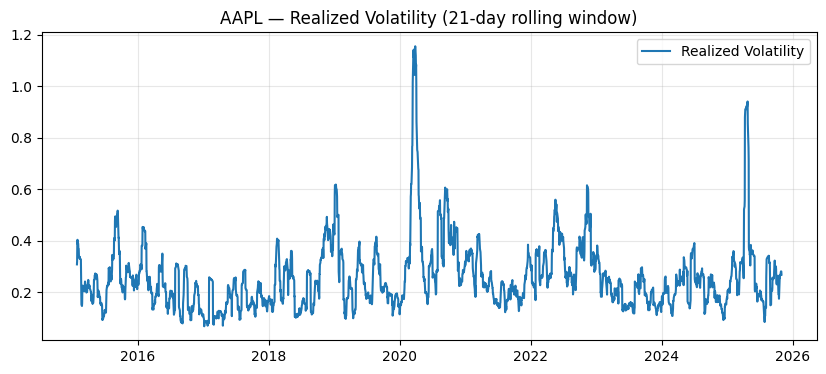

In [5]:
plt.figure(figsize=(10,4))
plt.plot(df_aapl["date"], df_aapl["realized_vol"], label="Realized Volatility")
plt.title("AAPL — Realized Volatility (21-day rolling window)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 5️⃣ Fetch data for multiple tickers

We’ll now pull OHLCV data for the entire universe at once using `build_dataset()`.

`build_dataset()` merges all ticker DataFrames into a **single standardized table**  with columns: 
`['date', 'return', 'realized_vol', 'ticker']`

In [6]:
multi_df = build_dataset(tickers=TICKERS, window=LOOKBACK, start=START_DATE, end=END_DATE)
multi_df

🌍 Fetching market data:   0%|          | 0/5 [00:00<?, ?ticker/s]

🌍 Fetching market data: 100%|██████████| 5/5 [00:01<00:00,  2.93ticker/s]


,date,return,realized_vol,ticker
0,2015-01-26,0.001062,0.308934,AAPL
1,2015-01-27,-0.035013,0.322127,AAPL
2,2015-01-28,0.056533,0.391716,AAPL
3,2015-01-29,0.031134,0.404300,AAPL
4,2015-01-30,-0.014634,0.387963,AAPL
...,...,...,...,...
13540,2025-10-24,0.008173,0.156622,SPY
13541,2025-10-27,0.011798,0.162710,SPY
13542,2025-10-28,0.002656,0.161205,SPY
13543,2025-10-29,0.000480,0.160229,SPY


## 6️⃣ Generate advanced features

`build_features()` adds all derived metrics used by the models, such as:
- Rolling volatilities (`vol_3d`, `vol_10d`, `vol_ratio`, etc.)
- Market stress and skewness features
- Calendar encodings (`month_sin`, `month_cos`, `day_of_week`)
- EWMA and volatility of volatility measures

`realized_log_vol` is usually set as the target column, to assist with better generalization for model training.

In [7]:
multi_df = build_features(multi_df)
multi_df.head()

,return,ticker,date,realized_vol,realized_vol_log,abs_return,day_of_week,ret_sq,vol_ratio,month_cos,vol_vol,vol_chg,month_sin,skew_5d,vol_10d,market_stress,vol_3d,market_stress_1d_lag,ewma_vol_10d
0,0.001062,AAPL,2015-01-26,0.308934,-1.174623,0.001062,0.000000,0.000001,0.999997,0.866025,NaN,0.000000,0.5,NaN,0.308934,0.003203,0.308934,NaN,0.308934
1,-0.035013,AAPL,2015-01-27,0.322127,-1.132806,0.035013,0.166667,0.001226,0.999997,0.866025,0.009329,0.000000,0.5,NaN,0.315531,0.031067,0.315531,0.003203,0.311333
2,0.056533,AAPL,2015-01-28,0.391716,-0.937216,0.056533,0.333333,0.003196,0.999997,0.866025,0.044477,0.000000,0.5,0.252505,0.340926,0.034822,0.340926,0.031067,0.325948
3,0.031134,AAPL,2015-01-29,0.404300,-0.905595,0.031134,0.500000,0.000969,1.044690,0.866025,0.048197,0.015945,0.5,-0.187518,0.356769,0.008002,0.372714,0.034822,0.340194
4,-0.014634,AAPL,2015-01-30,0.387963,-0.946842,0.014634,0.666667,0.000214,1.087190,0.866025,0.044009,0.031652,0.5,0.220791,0.363008,0.010713,0.394660,0.008002,0.348879


## 7️⃣ Inspect available features
Let’s verify all the generated columns now present in the dataset.

In [8]:
print("Feature columns:")
print([col for col in multi_df.columns if col not in ["ticker", "date"]])

Feature columns:
['return', 'realized_vol', 'realized_vol_log', 'abs_return', 'day_of_week', 'ret_sq', 'vol_ratio', 'month_cos', 'vol_vol', 'vol_chg', 'month_sin', 'skew_5d', 'vol_10d', 'market_stress', 'vol_3d', 'market_stress_1d_lag', 'ewma_vol_10d']


## 8️⃣ Visualize a feature — e.g. 3-day vs 10-day volatility

This helps confirm feature dynamics and sanity-check the rolling window logic.

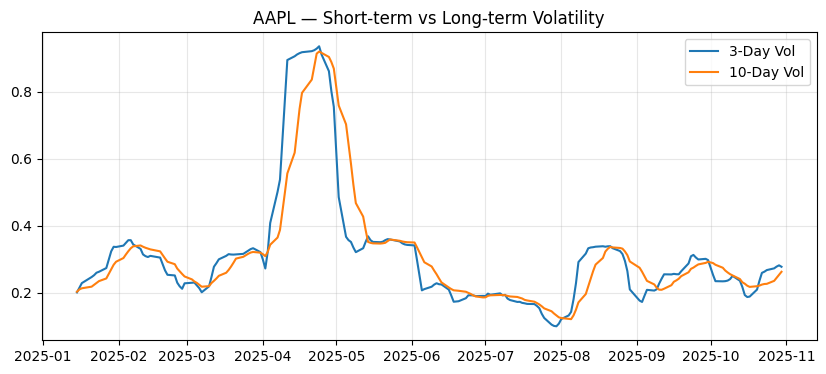

In [9]:
sample = multi_df[multi_df["ticker"] == "AAPL"].tail(200)
plt.figure(figsize=(10,4))
plt.plot(sample["date"], sample["vol_3d"], label="3-Day Vol")
plt.plot(sample["date"], sample["vol_10d"], label="10-Day Vol")
plt.title("AAPL — Short-term vs Long-term Volatility")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 9️⃣ Save processed datasets

We’ll store the processed DataFrame in `data/processed/`  
so it can be reused in model training and inference notebooks.

In [20]:
os.makedirs("../data/processed", exist_ok=True)
multi_df.to_csv("../data/processed/global_volatility_dataset.csv", index=False)
df_aapl.to_csv("../data/processed/aapl_volatility_dataset.csv", index=False)
print("✅ Saved processed dataset to ../data/processed/global_volatility_dataset.csv")
print("✅ Saved processed dataset to ../data/processed/aapl_volatility_dataset.csv")

✅ Saved processed dataset to ../data/processed/global_volatility_dataset.csv
✅ Saved processed dataset to ../data/processed/aapl_volatility_dataset.csv


# 🔟 Summary

We have successfully:

- Pulled OHLCV data for multiple tickers  
- Computed returns and realized volatility  
- Generated an extensive set of volatility-related features  
- Saved a clean, consolidated dataset for downstream modeling

Next → [2_model_training.ipynb](./2_model_training.ipynb)